<img align="right" src="../../../additional_data/banner_siegel.png" style="width:1000px;">

# Exercise for basic analysis 

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from your browser
* **Compatibility:** Notebook currently compatible with the Open Data Cube environments of the University of Wuerzburg


## Load packages and connect to eo2cube datacube

Import following libraries 

* datacube 
* matplotlib.pyplot as plt 
* geopandas as gpd
* with_ui_cbk from odc.ui 
* rgb from dea_tools.plotting 

And then, connect to eo2cube dataset. 

In [1]:
import datacube
import matplotlib.pyplot as plt
import geopandas as gpd
from odc.ui import with_ui_cbk
from dea_tools.plotting import rgb 

dc = datacube.Datacube(app = "Exercise_for_basic_analysis")

## Read shapefile 

1. Read "fields3" shapefile in data folder using `read_file` function from geopandas package. If you are interested in handling vector data in python, read `III_process_vector_data.ipynb`

In [2]:
aoi = gpd.read_file('./data/fields3.shp')

2. Use [`total_bounds`]("https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html) function from geopandas and set logitude and latitude extents. You can use these extents for loading datacube dataset. The arguments will be logitude and latitude instead of x and y. 

In [3]:
longitude_extents = (aoi.total_bounds[0] , aoi.total_bounds[2] )
latitude_extents  = (aoi.total_bounds[1] , aoi.total_bounds[3] )

print(latitude_extents, longitude_extents)

(-29.110722579435034, -29.081722542623123) (24.542999070639375, 24.594895806014275)


Load Sentinel-2 data from the eo2cube datacube with dc.load() function and following options.<br> 

* Longitude range: longitude extents from the shapefile <br> 
* Latitude range: latitude extents from the shapefile <br> 
* Time range: 2020-01-01 to 2020-04-30 <br> 
* Bands: blue, green, red, Near Infrared, a Scene Classification map <br> 
* Output coordinate system: EPSG:32734 <br> 
* Resolution: 10m <br> 
* Select only solar days 
* Use loading bar


In [4]:
ds = dc.load(product= "s2_l2a",
             latitude = latitude_extents,
             longitude = longitude_extents,
             output_crs = "EPSG:32734",
             time = ("2020-01-01", "2020-04-30"),
             measurements = ["blue", "green","red","nir","SCL"],
             resolution = (-10,10),
             group_by = "solar_day",
             progress_cbk=with_ui_cbk())

ds

/opt/conda/lib/python3.9/site-packages/datacube/drivers/postgres/_api.py:564: SAWarning: Class CommonTimestamp will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  return self._connection.execute(select_query)
/opt/conda/lib/python3.9/site-packages/datacube/drivers/postgres/_api.py:564: SAWarning: Class Float8Range will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  

<xarray.Dataset>
Dimensions:      (time: 47, y: 338, x: 516)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-03T08:38:19 ... 2020-04-29T08:...
  * y            (y) float64 6.778e+06 6.778e+06 ... 6.774e+06 6.774e+06
  * x            (x) float64 8.448e+05 8.448e+05 8.449e+05 ... 8.5e+05 8.5e+05
    spatial_ref  int32 32734
Data variables:
    blue         (time, y, x) uint16 631 631 669 669 686 ... 370 363 323 335 349
    green        (time, y, x) uint16 1132 1132 1158 1204 ... 703 691 644 661
    red          (time, y, x) uint16 1814 1814 2000 1972 ... 611 606 601 567
    nir          (time, y, x) uint16 3296 3296 3370 3408 ... 2646 2526 2380 2510
    SCL          (time, y, x) uint8 5 5 5 5 5 5 5 5 5 5 ... 4 4 5 5 4 4 4 4 4 4
Attributes:
    crs:           EPSG:32734
    grid_mapping:  spatial_ref

## Basic analysis

1. Plot the dataset of the fourth time stamp as True Color Composite with `rgb` function 

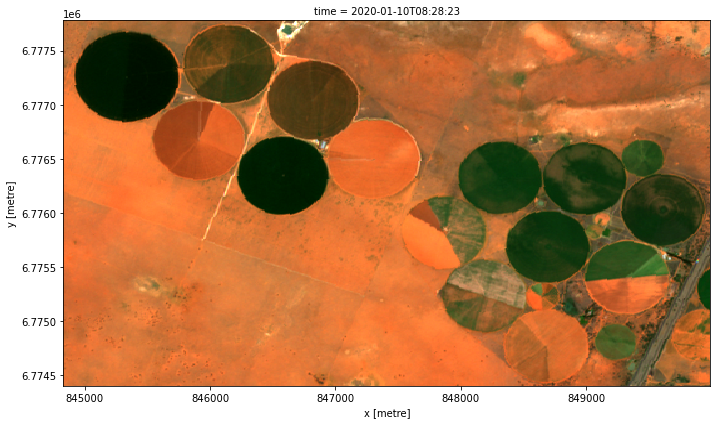

In [5]:
rgb(ds.isel(time=[3]), bands=['red', 'green', 'blue'], col="time")

2. Mask clouds by using `where` function and SCL band. (Hint: 06_plotting_basics.ipynb)

In [6]:
ds_cloud_masked = ds.where(ds.SCL != 9)

3. Group by month and calculate the monthly Median. And see the result. 

In [7]:
ds_median = ds_cloud_masked.groupby('time.month').median()
ds_median

<xarray.Dataset>
Dimensions:      (month: 4, y: 338, x: 516)
Coordinates:
  * y            (y) float64 6.778e+06 6.778e+06 ... 6.774e+06 6.774e+06
  * x            (x) float64 8.448e+05 8.448e+05 8.449e+05 ... 8.5e+05 8.5e+05
    spatial_ref  int32 32734
  * month        (month) int64 1 2 3 4
Data variables:
    blue         (month, y, x) float64 631.0 631.0 669.0 ... 333.0 333.0 326.0
    green        (month, y, x) float64 1.082e+03 1.082e+03 ... 676.0 653.0
    red          (month, y, x) float64 1.762e+03 1.762e+03 ... 606.0 567.0
    nir          (month, y, x) float64 2.93e+03 2.93e+03 ... 2.676e+03 2.916e+03
    SCL          (month, y, x) float64 5.0 5.0 5.0 5.0 5.0 ... 4.0 4.0 4.0 4.0

4. Plot the first motnly median image using `rgb` function.

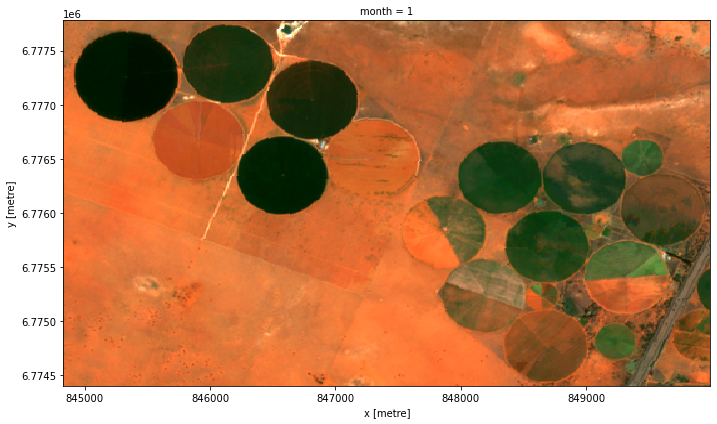

In [8]:
rgb(ds_median.isel(month=[0]), bands=['red', 'green', 'blue'], col="month")

5. Calculate NDVI and add it into our monthly median dataset. 

In [9]:
ndvi = (ds_median.nir - ds_median.red)/(ds_median.nir +ds_median.red)
ds_median = ds_median.assign(ndvi=ndvi)

6. Compare January and April monthly median NDVI images. Set one row and two colums using `nrow` and `ncol` argument in the `subplot` function from `matplotlib` package. Recommened color map is "RdYlGn"

Text(0.5, 1.08, 'Monthly Median NDVI Comparison between Jan. and Apr. 2020')

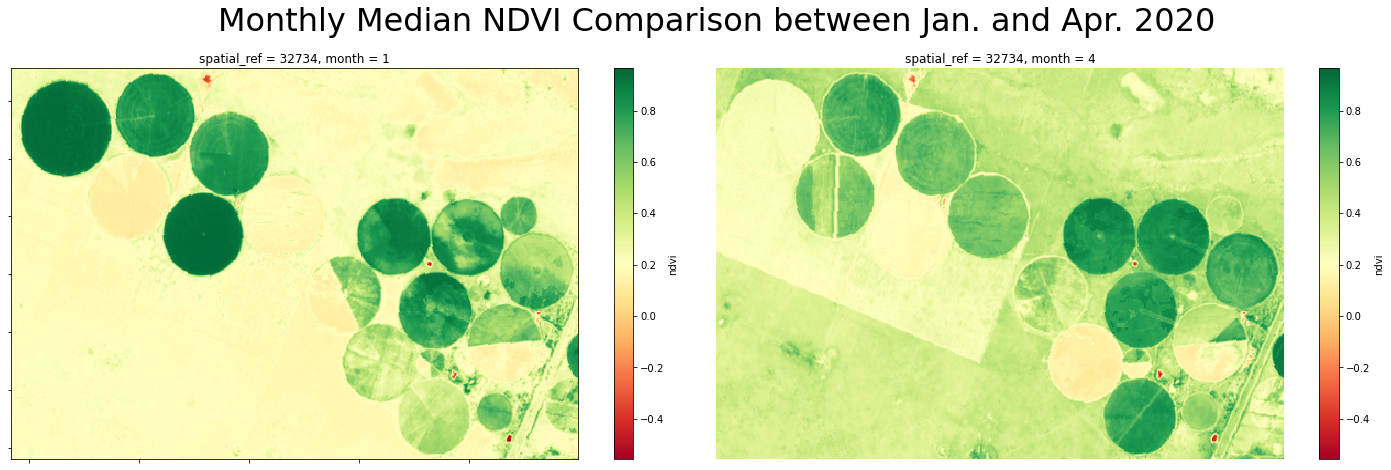

In [10]:
#sns.set(font_scale=1.5) #scale the texts in plot to 1.5
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6)) #plot subplots

ds_median['ndvi'].sel(month=1).plot(ax=axes[0], vmin=ndvi.min(), vmax=ndvi.max(), cmap='RdYlGn', robust=True)
ds_median['ndvi'].sel(month=4).plot(ax=axes[1], vmin=ndvi.min(), vmax=ndvi.max(), cmap='RdYlGn', robust=True)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([]) #empty x ticks
    ax.axes.get_yaxis().set_ticklabels([]) #empty y ticks
    ax.set_xlabel('') #empty x label
    ax.set_ylabel('') #empty y label
    
plt.axis("off") #remove all axis
plt.tight_layout() #adjust excessive padding
fig.suptitle('Monthly Median NDVI Comparison between Jan. and Apr. 2020', fontsize=32, y=1.08)

***

## Additional information

<font size="2">This notebook for the usage in the Open Data Cube entities of the [Department of Remote Sensing](http://remote-sensing.org/), [University of Wuerzburg](https://www.uni-wuerzburg.de/startseite/), is adapted from [Geoscience Australia](https://github.com/GeoscienceAustralia/dea-notebooks), published using the Apache License, Version 2.0. Thanks! </font>

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.


**Contact:** If you would like to report an issue with this notebook, you can file one on [Github](https://github.com).

**Last modified:** June 2022